Create a VGG model from scratch

In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image


Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Model creation


In [2]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
        

In [3]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

Copy data pre-processing code

In [4]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

define vgg model architecture

In [5]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    # original classification problem over 1000 classes
    model.add(Dense(1000, activation='softmax'))
    return model

In [6]:
model = VGG_16()

In [7]:
FILES_PATH = 'http://www.platform.ai/models/'
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

setup methods for grabbing the data

In [8]:
batch_size=64
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

grab the data

In [9]:
batches = get_batches('data/dogs-vs-cats-redux/train', batch_size=batch_size)
val_batches = get_batches('data/dogs-vs-cats-redux/valid', batch_size=batch_size)


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Manually fine-tune model by removing the last layer, setting all remaining layers as not trainable and then adding new final layer for binary classification

In [10]:
model.pop()
for layer in model.layers:
    layer.trainable = False
# why specifying inpuy shape in model.add here?
model.add(Dense(2, activation='softmax'))
# fixed learning rate here
model.compile(optimizer=RMSprop(lr=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
num_epoch=1
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
22500/22500 [==============================] - 628s - loss: 0.6736 - acc: 0.9556 - val_loss: 0.2363 - val_acc: 0.9852


In [17]:
%matplotlib inline
from __future__ import division,print_function
from matplotlib import pyplot as plt
# use provided utility functions
import utils; reload(utils)
from utils import plots

Found 12500 images belonging to 1 classes.


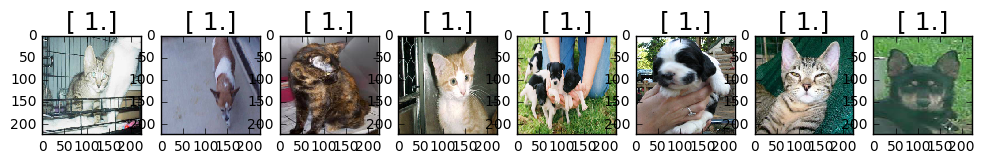

In [22]:
# load some sample test data
test_batches = get_batches('data/dogs-vs-cats-redux/test', shuffle=False, batch_size=8)
#fnames = test_batches.filenames
imgs,labels = next(test_batches)
plots(imgs, titles=labels)

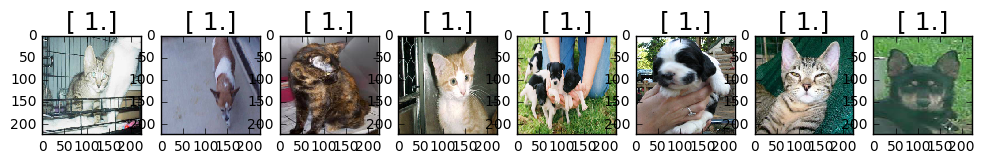

In [23]:
plots(imgs, titles=labels)

In [20]:
model.predict(imgs)

array([[  1.0000e+00,   0.0000e+00],
       [  2.2055e-10,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   0.0000e+00]], dtype=float32)

In [24]:
model.predict_proba(imgs)

8/8 [==============================] - 0s


array([[  1.0000e+00,   0.0000e+00],
       [  2.2055e-10,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  0.0000e+00,   1.0000e+00],
       [  0.0000e+00,   1.0000e+00],
       [  1.0000e+00,   0.0000e+00],
       [  4.6568e-09,   1.0000e+00]], dtype=float32)

In [25]:
test_preds = model.predict(imgs)
test_idxs = np.argmax(test_preds, axis=1)
test_preds = [test_preds[i, test_idxs[i]] for i in range(len(test_idxs))]
test_preds
test_idxs

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]